In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import load_model
from keras import layers
import os
import tensorflow as tf
import datetime
from collections import deque
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax
import torch


c:\Users\gusta\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\gusta\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
c:\Users\gusta\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
def initialize_dataframes(file_path):
    df = pd.read_csv(file_path)
    df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[['Date', 'Close']]
    df.index = df.pop('Date')
    return df

def init_dfs():
    df_all = initialize_dataframes('NVDA.csv')
    train_df = initialize_dataframes('NVDA_train.csv')
    test_df = initialize_dataframes('NVDA_test.csv')
    return df_all, train_df, test_df

df_all, train_df, test_df = init_dfs()


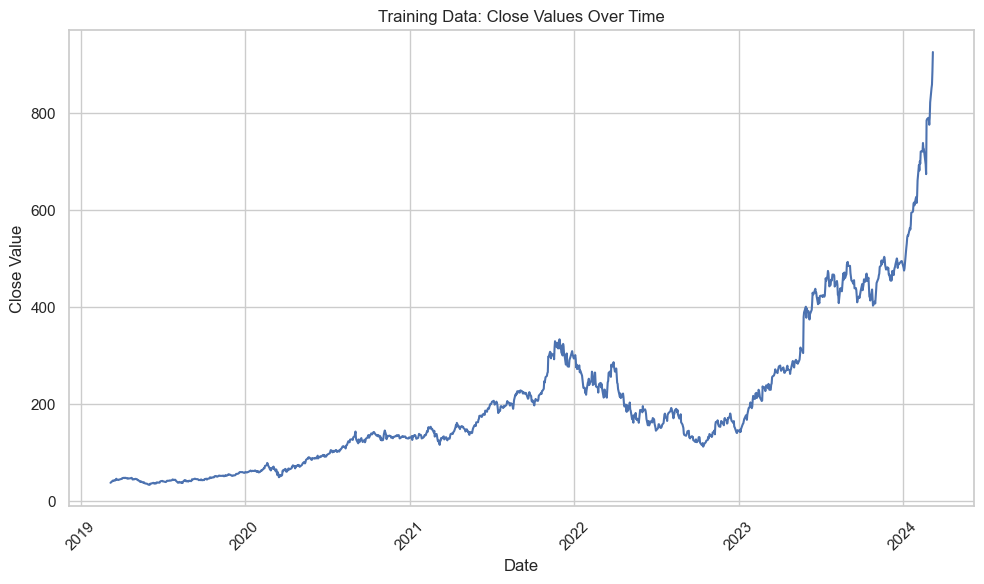

In [406]:
plt.figure(figsize=(10, 6))
plt.plot(df_all['Close'], marker='', linestyle='-')
plt.title('Training Data: Close Values Over Time')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# datapreprocessing for lstm

In [3]:
def get_recommendation(actual_value, predicted_value, start_date, end_date):
    difference = predicted_value - actual_value

    if abs(difference) <= 0.05 * actual_value:
        recommendation = "Hold"
    elif difference > 0:
        recommendation = "Buy"
    else:
        recommendation = "Sell"

    print('='*100)
    print(f'{start_date} Stock present value:  {actual_value}')
    print(f'{end_date} Stock predicted value: {predicted_value}')
    if difference >= 0:
        print(f'Value of investment: +{difference}')
    else:
        print(f'Value of investment: -{abs(difference)}')
    print(f'Recommendation: {recommendation}')
    print('='*100)



In [4]:
def generate_windowed_dataset(dataframe, start_date_str, end_date_str, col_names, target_col, window_size):
    start_date = pd.to_datetime(start_date_str)
    end_date = pd.to_datetime(end_date_str)

    target_date = start_date
    dates = []
    X, y = [], []

    while True:
        window_data = dataframe.loc[:target_date].tail(window_size + 1)

        if len(window_data) != window_size + 1:
            print(f'Error: Window of size {window_size} is too large for date {target_date}')
            return

        values = window_data[col_names].values
        X.append(values[:-1])

        target_value = window_data[target_col].values[-1]  # Extract the target column value
        y.append(target_value)
        dates.append(target_date)

        next_date = target_date + pd.tseries.offsets.BDay(1)  # Move to the next business day

        if next_date > end_date:
            break

        # Move to the next trading day
        while next_date not in dataframe.index:
            next_date += pd.tseries.offsets.BDay(1)

        target_date = next_date

    ret_df = pd.DataFrame({'Target Date': dates})
    for i, col_name in enumerate(col_names):
        for j in range(window_size):
            ret_df[f'{col_name}-{window_size-j}'] = np.array(X)[:, j, i]
    ret_df[f'Target'] = y

    return ret_df


In [5]:
def prepare_dataset_for_lstm(windowed_dataframe):
    dates = windowed_dataframe['Target Date'].to_numpy()
    X = windowed_dataframe.iloc[:, 1:-1].to_numpy().reshape(len(windowed_dataframe), -1, 1)
    y = windowed_dataframe['Target'].to_numpy()
    return dates, X.astype(np.float32), y.astype(np.float32)


In [6]:
def normalize_data(df):
    for col in df.columns:
        col_mean = df[col].mean()
        col_std = df[col].std()
        df[col] = (df[col] - col_mean) / col_std
    return df

# LSTM Baseline

## preprocessing

In [468]:
df_all, train_df, test_df = init_dfs()

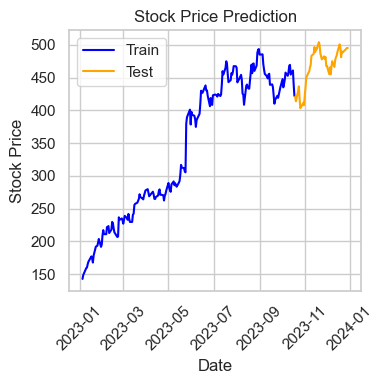

In [469]:
windowed_df = generate_windowed_dataset(train_df, '2023-01-05', '2023-12-29', ['Close'], 'Close', 3)
dates, X, y = prepare_dataset_for_lstm(windowed_df)

split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]
dates_train, dates_val = dates[:split], dates[split:]

# plot
plt.figure(figsize=(4, 4))
plt.plot(dates_train, y_train, label='Train', color='blue')
plt.plot(dates_val, y_val, label='Test', color='orange')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## training

In [ ]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)


save_dir = 'trained_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model.save(os.path.join(save_dir, 'baseline.keras'))

## plotting

7/7 [==============================] - 0s 1ms/step


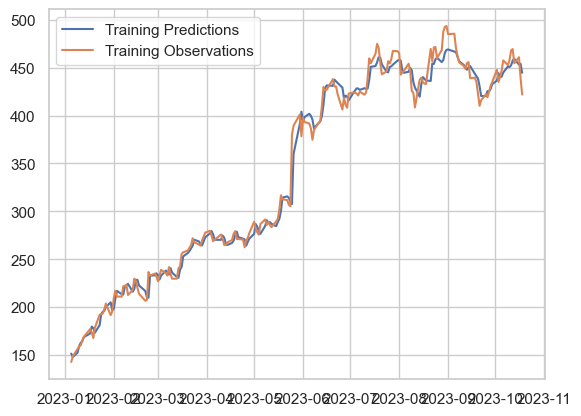

In [416]:
model = load_model('trained_models/baseline.keras')

train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 [==============================] - 0s 2ms/step


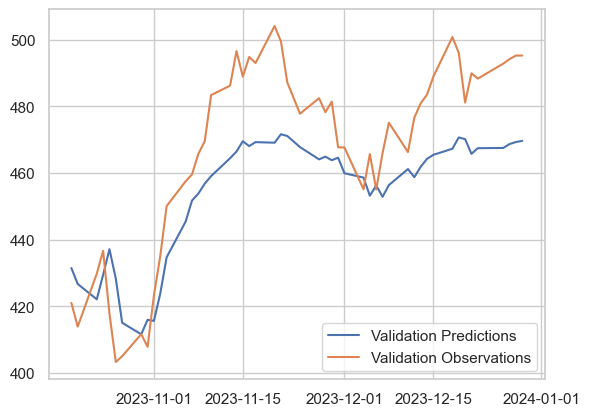

In [417]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

## evaluating on test set

Test MAE: 218.48404457867701
Test MSE: 62215.82752278224
Test RMSE: 249.43100754072705
2024-01-02 Stock present value:  481.679993
2024-03-07 Stock predicted value: 444.5417785644531
Value of investment: -37.1382144355469
Recommendation: Sell


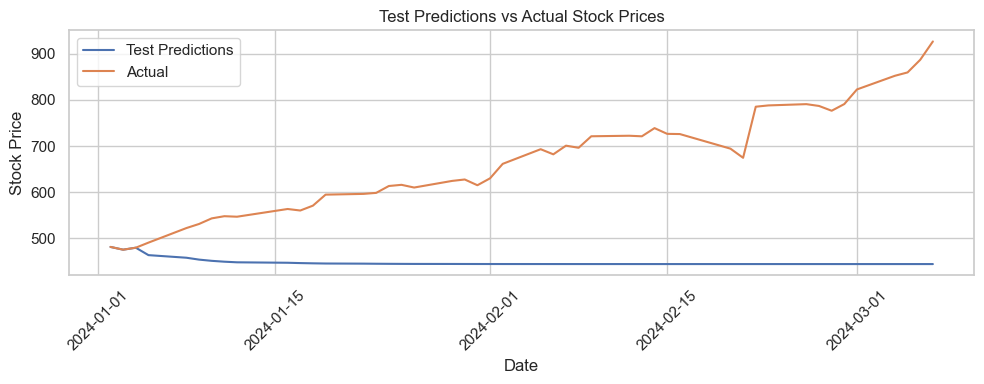

In [470]:
model = load_model('trained_models/baseline.keras')

n = 46
s = 0

values = test_df[['Close']].iloc[s:s+3].to_numpy().flatten().tolist()
dates = test_df.iloc[s:s+n].index.to_list()


measures = deque(values, maxlen=3)
measures_list = list(measures)

for date in range(n-3):
    x = np.array(measures, dtype=float).reshape((1,3,1))
    pred_measure = model.predict(x, verbose=0).flatten()[0]
    measures.append(pred_measure)
    values.append(pred_measure)


actual_values = test_df[['Close']].iloc[s:s+n].to_numpy().flatten().tolist()

mae_test = mean_absolute_error(actual_values, values)
mse_test = mean_squared_error(actual_values, values)
rmse_test = np.sqrt(mse_test)

print(f'Test MAE: {mae_test}')
print(f'Test MSE: {mse_test}')
print(f'Test RMSE: {rmse_test}')


get_recommendation(values[0], values[-1], datetime.strftime(dates[0], "%Y-%m-%d"),datetime.strftime(dates[-1], "%Y-%m-%d"))

plt.figure(figsize=(10, 4))
# plt.plot(df_all)
plt.plot(dates, values, label='Test Predictions')
plt.plot(dates, test_df[['Close']].iloc[s:s+n].to_numpy().flatten().tolist(), label='Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Test Predictions vs Actual Stock Prices')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Z-score scaling

## preprocessing

In [87]:
df_all, train_df, test_df = init_dfs()


train_mean = train_df['Close'].mean()
train_std = train_df['Close'].std()

test_mean = test_df['Close'].mean()
test_std = test_df['Close'].std()

# Apply z-score normalization
train_df['Close'] = (train_df['Close'] - train_mean) / train_std
test_df['Close'] = (test_df['Close'] - test_mean) / test_std

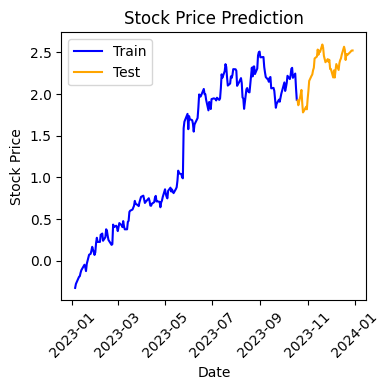

In [80]:
windowed_df = generate_windowed_dataset(train_df, '2023-01-05', '2023-12-29',  ['Close'], 'Close', 3)
dates, X, y = prepare_dataset_for_lstm(windowed_df)

split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]
dates_train, dates_val = dates[:split], dates[split:]

# plot
plt.figure(figsize=(4, 4))
plt.plot(dates_train, y_train, label='Train', color='blue')
plt.plot(dates_val, y_val, label='Test', color='orange')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## training

In [ ]:
model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape=(3, len(['Close']))))
model.add(Dropout(0.3))
model.add(LSTM(120, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(20))
model.add(Dense(1))

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])


save_dir = 'trained_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Define a ModelCheckpoint callback
checkpoint_path = os.path.join(save_dir, 'zscore_.keras')
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',  # Choose the metric to monitor
                             save_best_only=True,  # Save only the best model
                             mode='min',  # 'min' for validation loss, 'max' for accuracy, 'auto' for automatic
                             verbose=1)

# Train the model with the callback
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=1000,
                    callbacks=[checkpoint], verbose=0)

## plotting

2/2 [==============================] - 0s 3ms/step


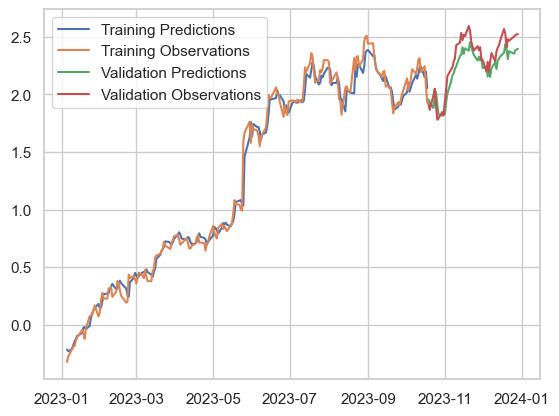

In [483]:
model = load_model('trained_models/zscore.keras')

train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions, label='Training Predictions')
plt.plot(dates_train, y_train, label='Training Observations')
plt.legend()

val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions, label='Validation Predictions')
plt.plot(dates_val, y_val, label='Validation Observations')
plt.legend()

plt.show()


## evaluating on test set

Test MAE: 49.025758922137804
Test MSE: 4025.1364969186457
Test RMSE: 63.443963439547545
2024-01-02 Stock present value:  481.679993
2024-03-07 Stock predicted value: 729.6974535690786
Value of investment: +248.01746056907854
Recommendation: Buy


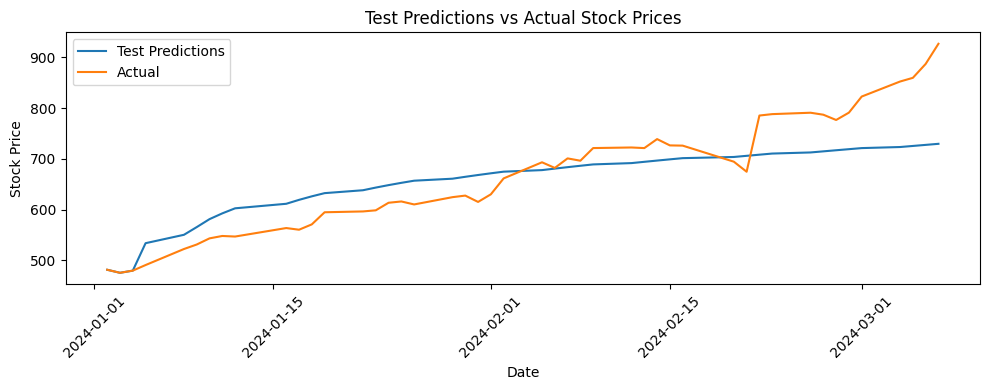

In [83]:
model = load_model('trained_models/zscore.keras')

n = 46
s = 0

values = test_df[['Close']].iloc[s:s+3].to_numpy().flatten().tolist()
dates = test_df.iloc[s:s+n].index.to_list()
measures = deque(values, maxlen=3)
measures_list = list(measures)

for date in range(n-3):
    x = np.array(measures, dtype=float).reshape((1,3,1))
    pred_measure = model.predict(x, verbose=0).flatten()[0]
    measures.append(pred_measure)
    values.append(pred_measure)

test_predictions = [(val * test_std) + test_mean for val in values]
actual_values = test_df[['Close']].iloc[s:s+n].to_numpy().flatten().tolist()
actual_values = [(val * test_std) + test_mean for val in actual_values]

mae_test = mean_absolute_error(actual_values, test_predictions)
mse_test = mean_squared_error(actual_values, test_predictions)
rmse_test = np.sqrt(mse_test)

print(f'Test MAE: {mae_test}')
print(f'Test MSE: {mse_test}')
print(f'Test RMSE: {rmse_test}')

get_recommendation(test_predictions[0], test_predictions[-1], datetime.strftime(dates[0], "%Y-%m-%d"), datetime.strftime(dates[-1], "%Y-%m-%d"))

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(dates, test_predictions, label='Test Predictions')
plt.plot(dates, actual_values, label='Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Test Predictions vs Actual Stock Prices')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



# Returns 

## preprocessing

In [471]:
df_all, train_df, test_df = init_dfs()

df_ret_train = train_df.copy()
df_ret_train['Return'] = df_ret_train['Close'].pct_change()
df_ret_train.drop(columns=['Close'], inplace=True)
df_ret_train.dropna(inplace=True)

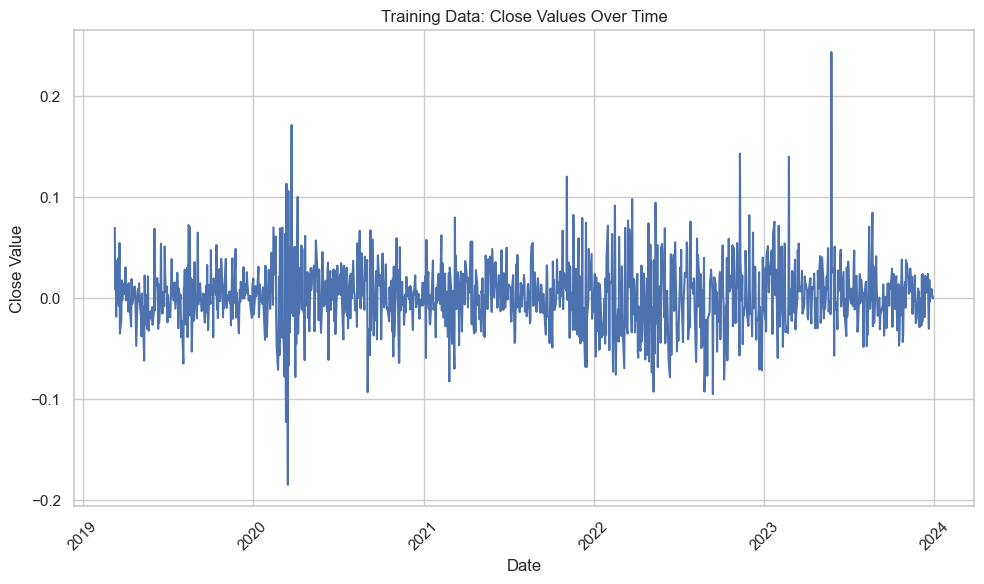

In [472]:
plt.figure(figsize=(10, 6))
plt.plot(df_ret_train.index, df_ret_train['Return'], marker='', linestyle='-')
plt.title('Training Data: Close Values Over Time')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


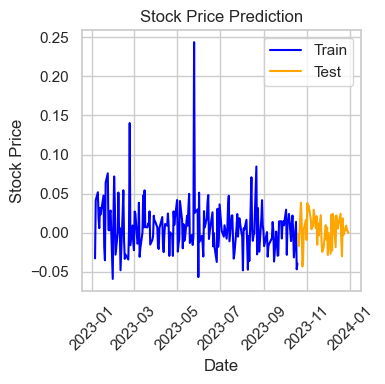

In [473]:
windowed_df = generate_windowed_dataset(df_ret_train, '2023-01-05', '2023-12-29', ['Return'], 'Return', 3)
dates, X, y = prepare_dataset_for_lstm(windowed_df)

split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]
dates_train, dates_val = dates[:split], dates[split:]

# plot
plt.figure(figsize=(4, 4))
plt.plot(dates_train, y_train, label='Train', color='blue')
plt.plot(dates_val, y_val, label='Test', color='orange')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Training

In [ ]:
model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape=(3, len(['Close']))))
model.add(LSTM(80, return_sequences=True))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(120, return_sequences=False))
model.add(Dense(20))
model.add(Dense(20))
model.add(Dense(1))

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.01),
              metrics=['mean_absolute_error'])


save_dir = 'trained_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Define a ModelCheckpoint callback
checkpoint_path = os.path.join(save_dir, 'return.keras')
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='loss',  # Choose the metric to monitor
                             save_best_only=True,  # Save only the best model
                             mode='min',  # 'min' for validation loss, 'max' for accuracy, 'auto' for automatic
                             verbose=0)

# Train the model with the callback
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=1000,
                    callbacks=[checkpoint], verbose=1)


## plotting

7/7 [==============================] - 1s 2ms/step


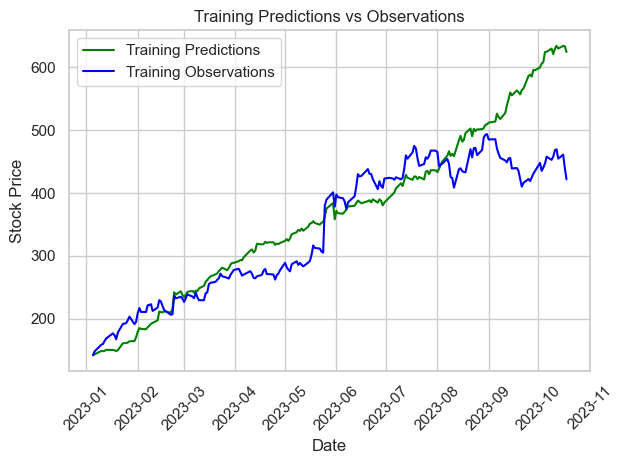

In [474]:
# Load the best model
return_model = load_model('trained_models/return.keras')

first_date = dates_train[0]
first_price = train_df.loc[first_date, 'Close']

train_predictions_pct_change = return_model.predict(X_train).flatten()
train_predictions = np.cumprod(1 + train_predictions_pct_change) * first_price


plt.plot(dates_train, train_predictions, color='green')

# Plot the real observations for the training dates
real_observations = [train_df.loc[date, 'Close'] for date in dates_train]
plt.plot(dates_train, real_observations, color='blue')

# Plot the predictions in the original price space
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Training Predictions vs Observations')
plt.legend(['Training Predictions', 'Training Observations'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

2/2 [==============================] - 0s 4ms/step


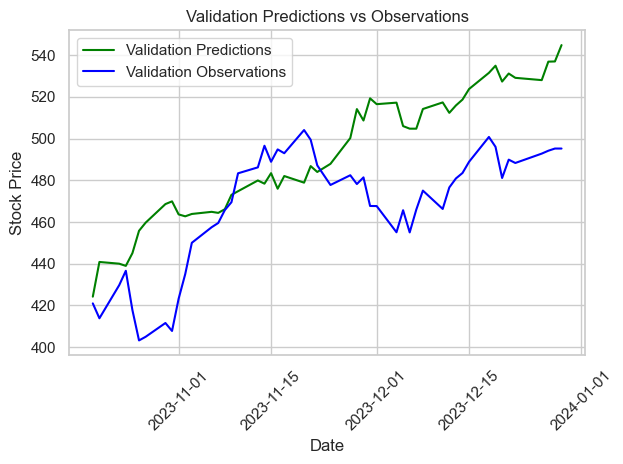

In [475]:
first_date_val = dates_val[0]
first_price_val = train_df.loc[first_date_val, 'Close']

# Obtain predictions for the validation set
val_predictions_pct_change = return_model.predict(X_val).flatten()
val_predictions = np.cumprod(1 + val_predictions_pct_change) * first_price_val


# Plot the validation predictions and observations
plt.plot(dates_val, val_predictions, color='green')

# Plot the real observations for the validation dates
real_observations_val = [train_df.loc[date, 'Close'] for date in dates_val]
plt.plot(dates_val, real_observations_val, color='blue')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Validation Predictions vs Observations')
plt.legend(['Validation Predictions', 'Validation Observations'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## evaluation on test set

Test MAE: 111.06144778345788
Test MSE: 18636.74499130487
Test RMSE: 136.51646417668775
2024-01-02 Stock present value:  485.3691711425781
2024-03-07 Stock predicted value: 605.3551025390625
Value of investment: +119.98593139648438
Recommendation: Buy


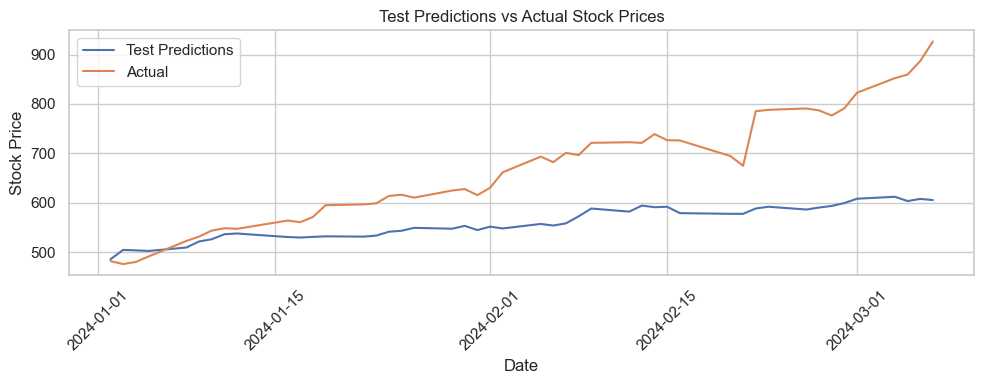

In [479]:
from keras.models import load_model
from keras.optimizers import Adam


model = load_model('trained_models/return.keras')

n = 46
s = 0

return_values_pct_change = test_df[['Close']].iloc[s:s+4].pct_change().dropna().to_numpy().flatten().tolist()
dates = test_df.iloc[s:s+n].index.to_list()

last_3_returns = deque(return_values_pct_change, maxlen=3)

for date in range(n-3):
    x = np.array(last_3_returns, dtype=float).reshape((1,3,1))
    test_predictions_pct_change = model.predict(x, verbose=0).flatten()[0]
    last_3_returns.append(test_predictions_pct_change)
    return_values_pct_change.append(test_predictions_pct_change)

first_test_value = test_df[['Close']].iloc[s, 0]
test_predictions = np.cumprod(1 + val_predictions_pct_change) * first_test_value
test_predictions = test_predictions[s:s+n]

actual_values = test_df[['Close']].iloc[s:s+n].to_numpy().flatten().tolist()

mae_test = mean_absolute_error(actual_values, test_predictions)
mse_test = mean_squared_error(actual_values, test_predictions)
rmse_test = np.sqrt(mse_test)

print(f'Test MAE: {mae_test}')
print(f'Test MSE: {mse_test}')
print(f'Test RMSE: {rmse_test}')

get_recommendation(test_predictions[0], test_predictions[-1], datetime.strftime(dates[0], "%Y-%m-%d"), datetime.strftime(dates[-1], "%Y-%m-%d"))


plt.figure(figsize=(10, 4))
# plt.plot(df)
plt.plot(dates, test_predictions, label='Test Predictions')
plt.plot(dates, actual_values, label='Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Test Predictions vs Actual Stock Prices')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Multivariate LSTM

## data preprocessing

In [7]:
def get_news_sentiment(news_df):

    model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(model_name)

    def get_sentiment(description):
        inputs = tokenizer(description, return_tensors="pt", truncation=True, padding=True)
        outputs = model(**inputs)
        logits = outputs.logits
        probs = softmax(logits, dim=1)
        sentiment_label = torch.argmax(probs).item()
        sentiment_score = probs[0][sentiment_label].item()
        return sentiment_label, sentiment_score

    def adjust_sentiment_label(label):
        return label - 1  # Adjust labels from default 0 to 4, to -1 to 3

    sentiments = news_df['Description'].apply(get_sentiment)
    news_df['Sentiment_Label'] = [sentiment[0] for sentiment in sentiments]
    news_df['Sentiment_Label'] = [adjust_sentiment_label(sentiment[0]) for sentiment in sentiments]
    news_df['Sentiment_Score'] = [sentiment[1] for sentiment in sentiments]

    return news_df

In [10]:

file_path = 'news_retrieval/nvidia_news.csv'

news_df = pd.read_csv(file_path, usecols=[0, 2])
news_df['Date'] = pd.to_datetime(news_df['Date'])
news_df.set_index('Date', inplace=True)

news_df = news_df.iloc[4:]

news_df = get_news_sentiment(news_df)
news_df.drop(news_df.columns.difference(['Sentiment_Label']), axis=1, inplace=True)



In [11]:
train_df = pd.read_csv('NVDA_train.csv')
train_df.drop(columns=['Open', 'High', 'Low', 'Adj Close'], inplace=True)
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = train_df[['Date', 'Close', 'Volume']]
train_df.index = train_df.pop('Date')

# Load index values from the CSV file
index_values = pd.read_csv('SPX.csv')[['Date', 'Close']]
index_values['Date'] = pd.to_datetime(index_values['Date'])
index_values.set_index('Date', inplace=True)

# Add a new column with the loaded index values and sentiment label from news
train_df = pd.merge(train_df, index_values, on='Date', how='left', suffixes=('', '_Index'))
train_df = pd.merge(train_df, news_df[['Sentiment_Label']], left_index=True, right_index=True, how='left')

# in case of no matching dates we fill with 0
train_df['Sentiment_Label'].fillna(0, inplace=True)

test_df = pd.read_csv('NVDA_test.csv')
test_df.drop(columns=['Open', 'High', 'Low', 'Adj Close'], inplace=True)
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df = test_df[['Date', 'Close', 'Volume']]
test_df.index = test_df.pop('Date')

train_mean = train_df['Close'].mean()
train_std = train_df['Close'].std()
test_mean = test_df['Close'].mean()
test_std = test_df['Close'].std()

train_df = normalize_data(train_df)
test_df = normalize_data(test_df)

feature_list = train_df.columns.to_list()
n_features = len(feature_list)
window_size = 3


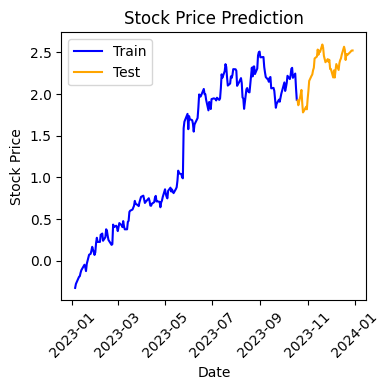

In [12]:
windowed_df = generate_windowed_dataset(train_df, '2023-01-05', '2023-12-29', feature_list, 'Close', window_size=3)
dates, X, y = prepare_dataset_for_lstm(windowed_df)


split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]
dates_train, dates_val = dates[:split], dates[split:]

# plot
plt.figure(figsize=(4, 4))
plt.plot(dates_train, y_train, label='Train', color='blue')
plt.plot(dates_val, y_val, label='Test', color='orange')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

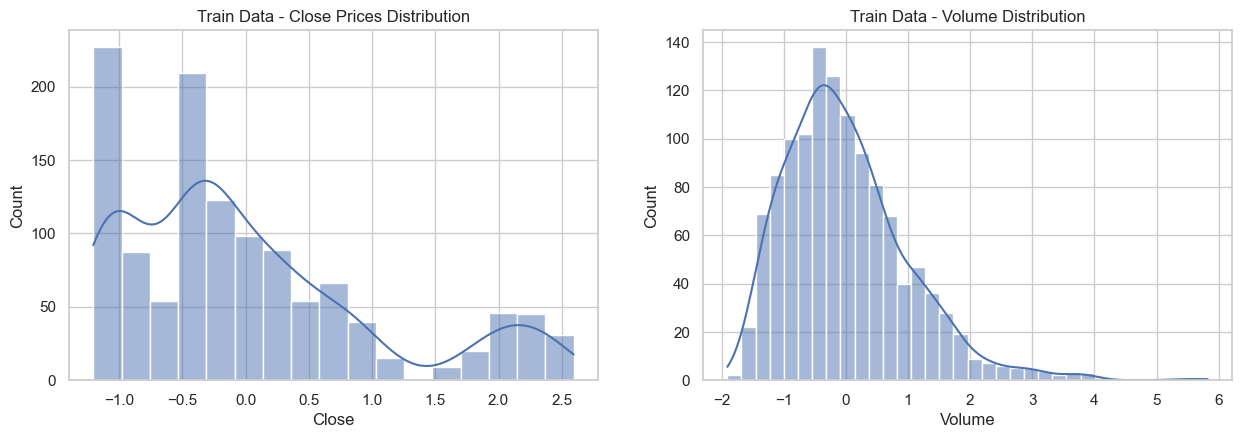

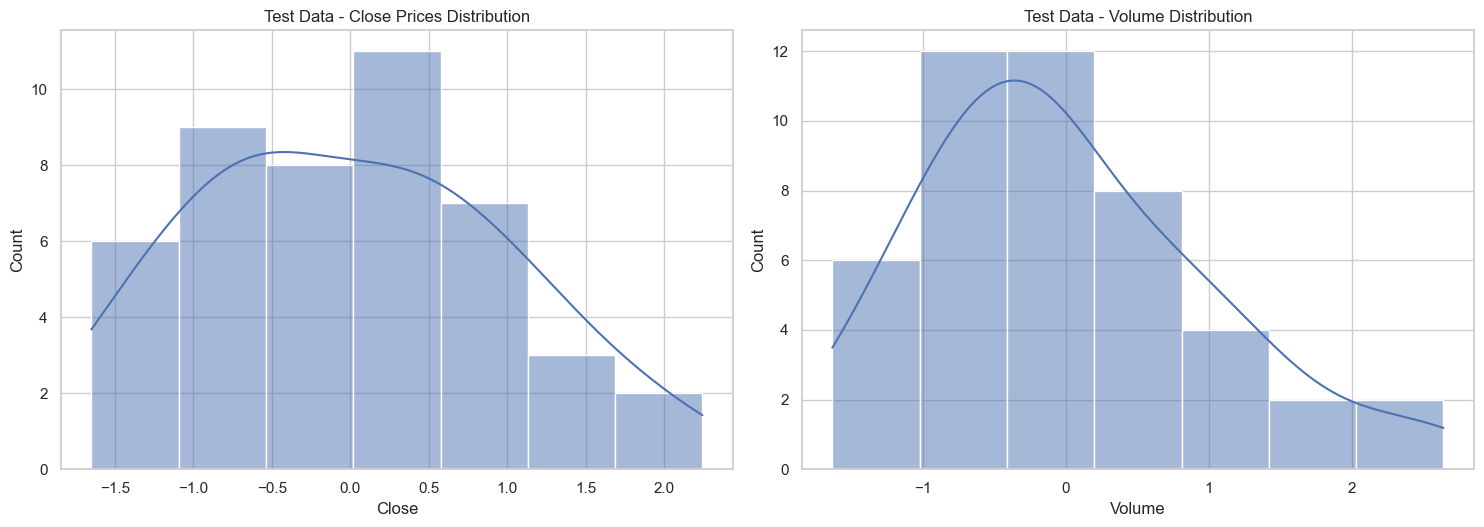

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns


# Set the style of seaborn for better aesthetics
sns.set_theme(style="whitegrid")

# Plotting for train_df
plt.figure(figsize=(15, 10))

# Plot Close prices distribution
plt.subplot(2, 2, 1)
sns.histplot(train_df['Close'], kde=True)
plt.title('Train Data - Close Prices Distribution')

# Plot Volume distribution
plt.subplot(2, 2, 2)
sns.histplot(train_df['Volume'], kde=True)
plt.title('Train Data - Volume Distribution')

# Plotting for test_df
plt.figure(figsize=(15, 10))

# Plot Close prices distribution
plt.subplot(2, 2, 3)
sns.histplot(test_df['Close'], kde=True)
plt.title('Test Data - Close Prices Distribution')

# Plot Volume distribution
plt.subplot(2, 2, 4)
sns.histplot(test_df['Volume'], kde=True)
plt.title('Test Data - Volume Distribution')

plt.tight_layout()
plt.show()


## training

In [14]:
model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape=(3 * n_features, len(['Close']))))
model.add(Dropout(0.2))
model.add(LSTM(80, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(120, return_sequences=False))
model.add(Dense(20))
model.add(Dropout(0.5))
model.add(Dense(20))
model.add(Dense(1))

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])


save_dir = 'trained_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Define a ModelCheckpoint callback
checkpoint_path = os.path.join(save_dir, 'multivariate_2.keras')
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',  # Choose the metric to monitor
                             save_best_only=True,  # Save only the best model
                             mode='min',  # 'min' for validation loss, 'max' for accuracy, 'auto' for automatic
                             verbose=1)

# Train the model with the callback
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    callbacks=[checkpoint], verbose=0)


Epoch 1: val_loss improved from inf to 0.07725, saving model to trained_models\multivariate_2.keras

Epoch 2: val_loss did not improve from 0.07725

Epoch 3: val_loss did not improve from 0.07725

Epoch 4: val_loss did not improve from 0.07725

Epoch 5: val_loss did not improve from 0.07725

Epoch 6: val_loss did not improve from 0.07725

Epoch 7: val_loss did not improve from 0.07725

Epoch 8: val_loss did not improve from 0.07725

Epoch 9: val_loss did not improve from 0.07725

Epoch 10: val_loss did not improve from 0.07725

Epoch 11: val_loss did not improve from 0.07725

Epoch 12: val_loss did not improve from 0.07725

Epoch 13: val_loss improved from 0.07725 to 0.04707, saving model to trained_models\multivariate_2.keras

Epoch 14: val_loss did not improve from 0.04707

Epoch 15: val_loss did not improve from 0.04707

Epoch 16: val_loss improved from 0.04707 to 0.03775, saving model to trained_models\multivariate_2.keras

Epoch 17: val_loss did not improve from 0.03775

Epoch 18

## plotting

2/2 [==============================] - 0s 5ms/step


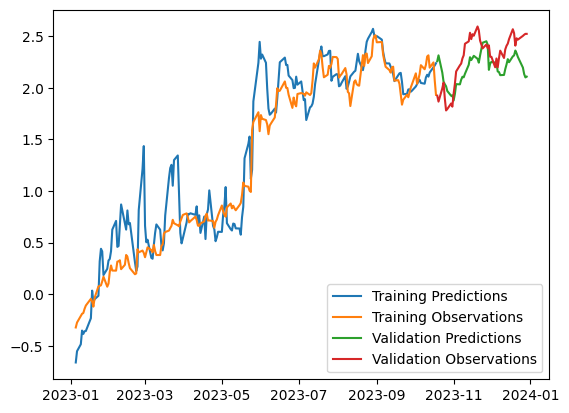

In [15]:
model = load_model('trained_models/multivariate.keras')

train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions, label='Training Predictions')
plt.plot(dates_train, y_train, label='Training Observations')
plt.legend()

val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions, label='Validation Predictions')
plt.plot(dates_val, y_val, label='Validation Observations')
plt.legend()

plt.show()


## evaluating on test set

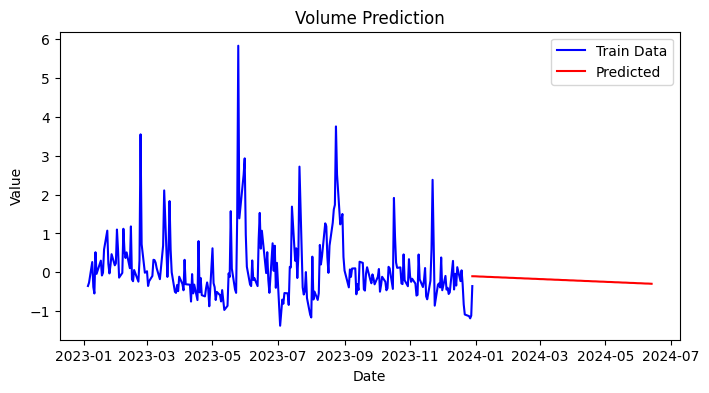

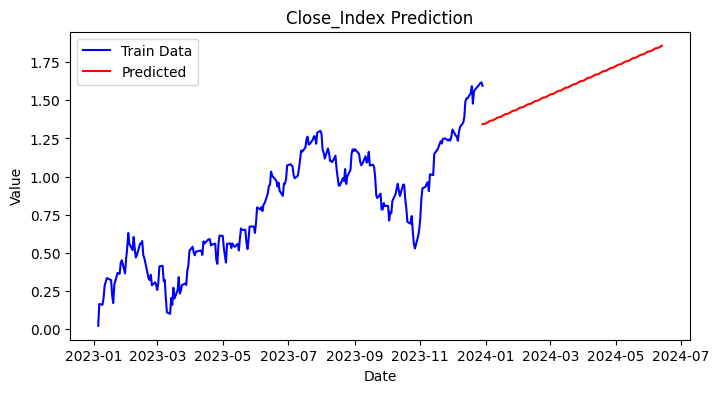

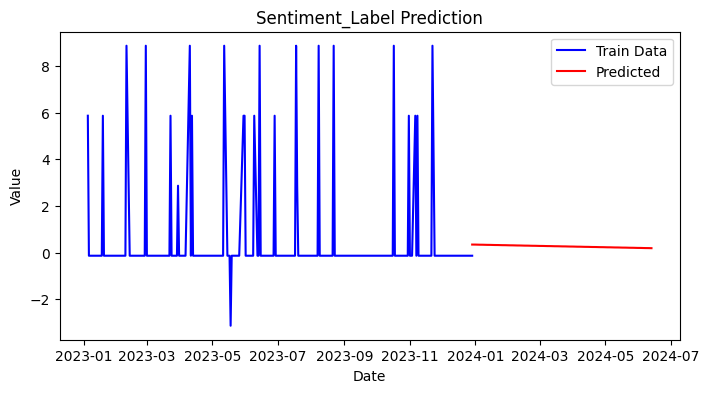

,Predicted_Volume,Predicted_Close_Index,Predicted_Sentiment_Label
2024-01-02,-0.103656,1.352740,0.344768
2024-01-03,-0.105284,1.357065,0.343462
2024-01-04,-0.106912,1.361390,0.342156
2024-01-05,-0.108540,1.365715,0.340850
2024-01-08,-0.110169,1.370040,0.339543
...,...,...,...
2024-06-07,-0.287646,1.841464,0.197156
2024-06-10,-0.289274,1.845789,0.195850
2024-06-11,-0.290903,1.850114,0.194544
2024-06-12,-0.292531,1.854439,0.193237


In [16]:
def predict_future_values(train_df, feature_columns, future_days):
    start_date = '2023-01-05'
    train_data = train_df.loc[start_date:]

    future_df = pd.DataFrame(index=pd.bdate_range(start=train_data.index[-1], periods=future_days))

    for feature_column in feature_columns:
        X_train = np.arange(len(train_data)).reshape(-1, 1)
        y_train = train_data[feature_column].values

        model = LinearRegression()
        model.fit(X_train, y_train)

        X_future = np.arange(len(train_data), len(train_data) + future_days).reshape(-1, 1)
        y_future_pred = model.predict(X_future)

        future_df[f'Predicted_{feature_column}'] = y_future_pred

        plt.figure(figsize=(8, 4))
        plt.plot(train_data.index, train_data[feature_column], label='Train Data', color='blue')
        plt.plot(future_df.index, y_future_pred, label='Predicted', color='red')
        plt.title(f'{feature_column} Prediction')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

    return future_df

future_features = feature_list.copy()
future_features.remove('Close')
future_days = 120
future_df = predict_future_values(train_df, future_features, future_days)
future_df = future_df.drop(future_df.index[:2], axis=0)
future_df


Test MAE: 22.00911768003436
Test MSE: 1000.8951561564996
Test RMSE: 31.636927097246655
2024-01-02 Stock present value:  484.6501163756973
2024-03-07 Stock predicted value: 914.719506510971
Value of investment: +430.0693901352737
Recommendation: Buy


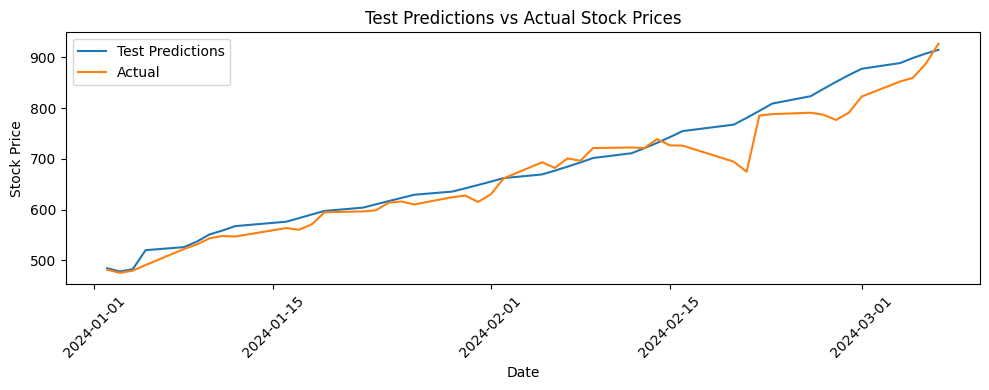

In [22]:
model = load_model('trained_models/multivariate.keras')

n = 46
s = 0

close_price_values = test_df['Close'].iloc[s:s+3].to_numpy().flatten().tolist()
volume_values = future_df['Predicted_Volume'].iloc[s:s+3].to_numpy().flatten().tolist()
index_close_price_values = future_df['Predicted_Close_Index'].iloc[s:s+3].to_numpy().flatten().tolist()
sentiment_label_values = future_df['Predicted_Sentiment_Label'].iloc[s:s+3].to_numpy().flatten().tolist()

dates = test_df.iloc[s:s+n].index.to_list()

close_price_deque = deque(close_price_values, maxlen=window_size)
volume_deque = deque(volume_values, maxlen=window_size)
index_deque = deque(index_close_price_values, maxlen=window_size)
sentiment_deque = deque(sentiment_label_values, maxlen=window_size)

for date in range(n-3):
    x = np.concatenate((np.array(close_price_deque).reshape((-1, 3)),
                        np.array(volume_deque).reshape((-1, 3)),
                        np.array(index_deque).reshape((-1, 3)),
                        np.array(sentiment_deque).reshape((-1, 3))
                        ),
                        axis=1)

    pred_measure = model.predict(x, verbose =0).flatten()[0]
    close_price_deque.append(pred_measure)
    volume_deque.append(future_df['Predicted_Volume'].iloc[date+3])
    sentiment_deque.append(future_df['Predicted_Sentiment_Label'].iloc[date+3])
    close_price_values.append(pred_measure)

offset = 500
test_predictions = [(val * train_std) + train_mean + offset for val in close_price_values]
actual_values = test_df[['Close']].iloc[s:s+n].to_numpy().flatten().tolist()
actual_values = [(val * test_std) + test_mean for val in actual_values]

mae_test = mean_absolute_error(actual_values[:n], test_predictions[:n])
mse_test = mean_squared_error(actual_values[:n], test_predictions[:n])
rmse_test = np.sqrt(mse_test)

print(f'Test MAE: {mae_test}')
print(f'Test MSE: {mse_test}')
print(f'Test RMSE: {rmse_test}')

get_recommendation(test_predictions[0], test_predictions[-1], datetime.strftime(dates[0], "%Y-%m-%d"), datetime.strftime(dates[-1], "%Y-%m-%d"))

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(dates, test_predictions, label='Test Predictions')
plt.plot(dates, actual_values, label='Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Test Predictions vs Actual Stock Prices')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()